# Industrial CO<sub>2</sub> Emission Analysis 

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
sns.set_style('darkgrid')
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from keras.preprocessing.sequence import TimeseriesGenerator
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import logging
logging.getLogger('NeuralProphet').setLevel(logging.CRITICAL)
from prophet.plot import plot_plotly, plot_components_plotly


In [30]:
#loading data

df = pd.read_csv('owid-world-data.csv')

In [31]:
df

,country,year,cement_co2,co2,coal_co2,flaring_co2,gas_co2,oil_co2
0,World,1750,NaN,9.351,9.351,NaN,NaN,NaN
1,World,1751,NaN,9.351,9.351,NaN,NaN,NaN
2,World,1752,NaN,9.354,9.354,NaN,NaN,NaN
3,World,1753,NaN,9.354,9.354,NaN,NaN,NaN
4,World,1754,NaN,9.358,9.358,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
267,World,2017,1507.923,36096.738,14506.974,391.992,7144.928,12242.628
268,World,2018,1569.218,36826.508,14746.831,412.116,7529.847,12266.017
269,World,2019,1617.507,37082.559,14725.978,439.254,7647.528,12345.653
270,World,2020,1637.537,35264.086,14174.564,407.584,7556.290,11191.809


In [32]:
ts = df[['year', 'co2']]

In [33]:
ts.rename(columns = {'year':'ds','co2':'y'}, inplace = True)


In [34]:
ts['ds'] = pd.to_datetime(ts['ds'], format='%Y')


In [35]:
ts

,ds,y
0,1750-01-01,9.351
1,1751-01-01,9.351
2,1752-01-01,9.354
3,1753-01-01,9.354
4,1754-01-01,9.358
...,...,...
267,2017-01-01,36096.738
268,2018-01-01,36826.508
269,2019-01-01,37082.559
270,2020-01-01,35264.086


In [36]:
ts.loc[ts['ds'] == '2020-01-01', 'y'] = (ts.loc[ts['ds'] == '2019-01-01', 'y'].values[0] + ts.loc[ts['ds'] == '2021-01-01', 'y'].values[0]) / 2


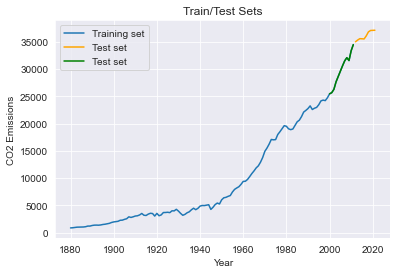

In [37]:
ts = ts[ts['ds'] > pd.Timestamp('1879-01-01')]

ts_train = ts[ts['ds'] < pd.Timestamp('2012-01-01')]
ts_val = ts[(ts['ds'] >= pd.Timestamp('2000-01-01')) & (ts['ds'] < pd.Timestamp('2012-01-01'))]
ts_test = ts[ts['ds'] >= pd.Timestamp('2012-01-01')]

plt.title('Train/Test Sets', size=12)
plt.plot(ts_train['ds'], ts_train['y'], label='Training set')
plt.plot(ts_test['ds'], ts_test['y'], label='Test set', color='orange')
plt.plot(ts_val['ds'], ts_val['y'], label='Test set', color='green')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend();

In [38]:
m1 = NeuralProphet(changepoints_range =.9,n_forecasts=2,n_lags=1)
m1.fit(ts_train, validation_df=ts_val, freq = 'YS')

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,1.316668,51225.816947,52576.823438,0.959429,0.0,0.962573,40063.992188,46382.222656
1,1.113562,45305.064724,46887.890865,0.803777,0.0,0.778497,32988.152344,40429.562500
2,0.912367,39254.692608,41144.988642,0.653101,0.0,0.620179,25889.474609,34679.554688
3,0.715403,33004.721394,35257.539904,0.505331,0.0,0.490572,23209.007812,29435.593750
4,0.520874,27065.626623,29289.888401,0.365415,0.0,0.391391,23076.955078,25214.052734
...,...,...,...,...,...,...,...,...
455,0.000091,271.231961,371.931098,0.000082,0.0,0.000240,503.807709,618.016785
456,0.000091,271.054015,375.905421,0.000081,0.0,0.000240,504.987213,618.495422
457,0.000091,271.025511,366.938757,0.000081,0.0,0.000241,506.477539,619.109253
458,0.000091,270.899847,372.477466,0.000081,0.0,0.000241,506.836243,619.260742


In [39]:
forecast1 = m1.predict(ts_test)
forecast1

,ds,y,residual1,yhat1,residual2,yhat2,ar1,ar2,trend,season_yearly
0,2012-01-01,35006.2700,NaN,None,NaN,None,None,None,None,None
1,2013-01-01,35319.2030,-64.777219,35254.425781,NaN,None,24234.800781,None,-6177.362305,17196.992188
2,2014-01-01,35577.5350,137.222812,35714.757812,507.875156,36085.410156,24456.859375,24827.513672,-5999.713867,17257.613281
3,2015-01-01,35558.5660,578.273844,36136.839844,993.105875,36551.671875,24640.171875,25055.003906,-5822.064453,17318.734375
4,2016-01-01,35524.1910,838.445719,36362.636719,1454.52775,36978.71875,24626.712891,25242.800781,-5644.417969,17380.34375
5,2017-01-01,36096.7380,236.289344,36333.027344,862.984656,36959.722656,24602.320312,25229.011719,-5466.282227,17196.992188
6,2018-01-01,36826.5080,151.070125,36977.578125,346.488094,37172.996094,25008.599609,25204.023438,-5288.635742,17257.613281
7,2019-01-01,37082.5590,651.636312,37734.195312,745.429281,37827.988281,25526.447266,25620.240234,-5110.987793,17318.734375
8,2020-01-01,37103.2055,1051.942938,38155.148438,1494.548406,38597.753906,25708.142578,26150.753906,-4933.338379,17380.34375
9,2021-01-01,37123.8520,1040.726125,38164.578125,1654.823781,38778.675781,25722.794922,26336.890625,-4755.206055,17196.992188


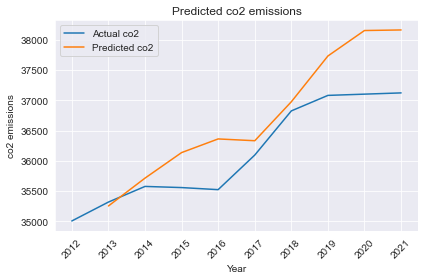

In [40]:
fig, ax = plt.subplots()


ax.plot(forecast1['ds'], forecast1['y'], label='Actual co2')
ax.plot(forecast1['ds'], forecast1['yhat1'], label='Predicted co2')


ax.set_title('Predicted co2 emissions')
ax.set_xlabel('Year')
ax.set_ylabel('co2 emissions')


ax.legend()


plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [41]:
#dropping lag
true_forecast = forecast1.dropna()

In [67]:
m1_mae = mean_absolute_error(true_forecast['y'], true_forecast['yhat1'])
m1_rmse = mean_squared_error(true_forecast['y'], true_forecast['yhat1'], squared=False)
m1_mape = mean_absolute_percentage_error(true_forecast['y'], true_forecast['yhat1'])
m1_r2 = r2_score(true_forecast['y'], true_forecast['yhat1'])

In [70]:
print(f'RMSE: {m1_rmse}\nMAE: {m1_mae}\nMAPE: {m1_mape}\nR2: {m1_r2}')


RMSE: 684.5802996494995
MAE: 585.7009023437504
MAPE: 0.016041023211755597
R2: 0.03816202991165063


## Conclusions

#### Space Holder

#### Space Holder

####  Space Holder

## Next Steps
